In [90]:
import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler

from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score, roc_curve, auc
from sklearn import preprocessing
from sklearn import neighbors

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDClassifier, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# 1.描述性统计分析

In [91]:
df_train = pd.read_csv('application_train.csv')
df_test = pd.read_csv('application_test.csv')

In [92]:
# 查看数据构成
print('the shape of train data：%s，the shape of test data：%s' % (df_train.shape, df_test.shape))

the shape of train data：(307511, 122)，the shape of test data：(48744, 121)


In [93]:
#查看数据的类型
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


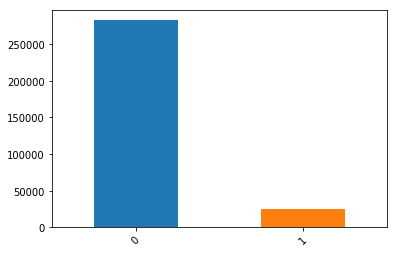

In [5]:
# 因变量TARGET分布
ax = df_train.TARGET.value_counts().plot(kind='bar',rot=45)

In [94]:
target=df_train['TARGET']
df_train_x=df_train.drop(['TARGET'],axis=1)

In [95]:
#合并训练集与测试集的
df_x=pd.concat([df_train_x,df_test],axis=0)

In [96]:
#划分定性变量与定量变量
quantitative = [feature for feature in df_train.columns if df_train.dtypes[feature] != 'object'] # 定量变量
quantitative.remove('SK_ID_CURR')
quantitative.remove('TARGET')
qualitative = [feature for feature in df_train.columns if df_train.dtypes[feature] == 'object'] # 定性变量

In [10]:
#对定性变量进行数值化编码。变量每个类别值对应的target均值排序，相应的对每个类别值赋值1，2，3...
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering['val']
    ordering['spmean'] = frame[[feature, 'TARGET']].groupby(feature)['TARGET'].mean()
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = np.arange(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict() # 返回的数据样例{category1:1, category2:2, ...}

    # 对frame[feature]编码
    for category, code_value in ordering.items():
        frame.loc[frame[feature]==category, feature+'_E'] = code_value
qual_encoded = []
for qual in qualitative:
    encode(df_train, qual)
    qual_encoded.append(qual+'_E')
print(qual_encoded)

['NAME_CONTRACT_TYPE_E', 'CODE_GENDER_E', 'FLAG_OWN_CAR_E', 'FLAG_OWN_REALTY_E', 'NAME_TYPE_SUITE_E', 'NAME_INCOME_TYPE_E', 'NAME_EDUCATION_TYPE_E', 'NAME_FAMILY_STATUS_E', 'NAME_HOUSING_TYPE_E', 'OCCUPATION_TYPE_E', 'WEEKDAY_APPR_PROCESS_START_E', 'ORGANIZATION_TYPE_E', 'FONDKAPREMONT_MODE_E', 'HOUSETYPE_MODE_E', 'WALLSMATERIAL_MODE_E', 'EMERGENCYSTATE_MODE_E']


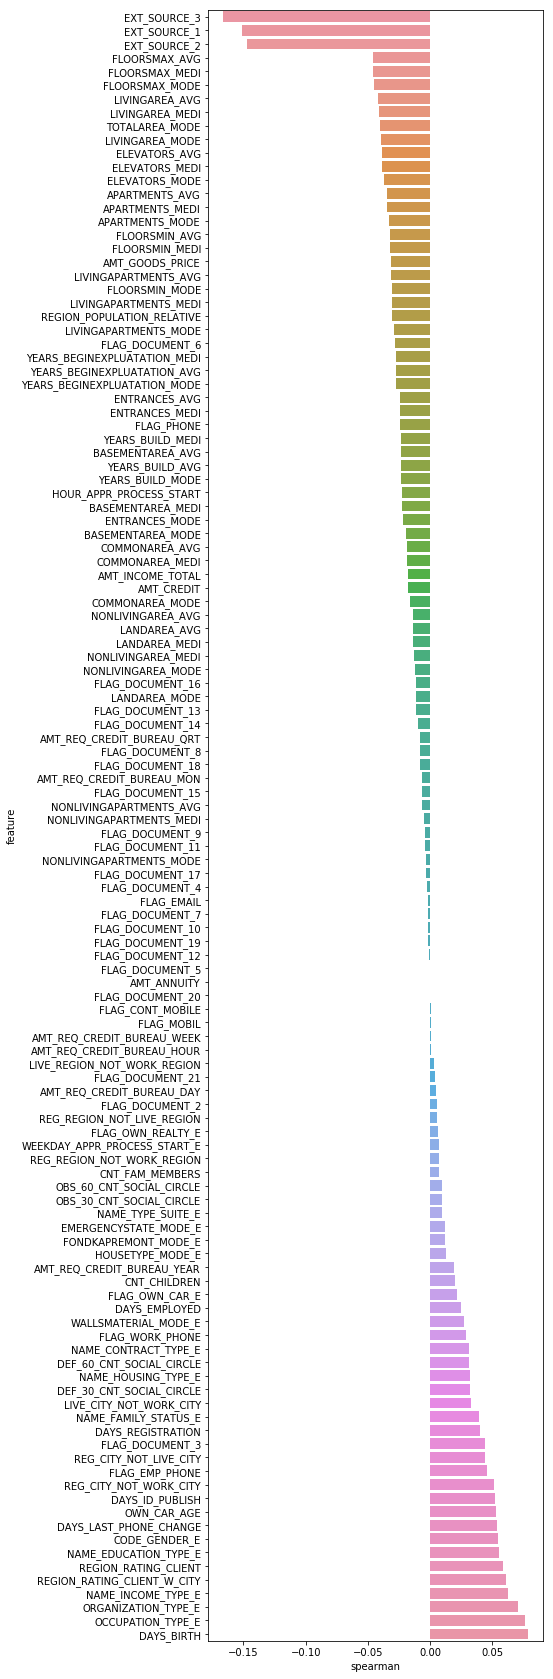

In [11]:
# 计算特征变量与target的spearman相关系数
def spearman(frame, features):
    spr =  pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['TARGET'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')

    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(x='spearman', y='feature', data=spr)
    
spearman(df_train, quantitative+qual_encoded)

# 2.变量选择与数据处理

In [69]:
#计算各变量的膨胀因子VIF，VIF较大的变量具有较强的多重共线性，可删除
candidates=quantitative+qual_encoded

def vif(df,col_i):
    from statsmodels.formula.api import ols
    cols=list(df.columns)
    cols.remove(col_i)
    cols_noti=cols
    formula=col_i+'~'+'+'.join(cols_noti)
    r2=ols(formula,df).fit().rsquared
    return 1/(1-r2)

exog=df_train[candidates]
for i in exog.columns:
    print(i,'t',vif(df=exog,col_i=i))

CNT_CHILDREN t 6.848866124790195
AMT_INCOME_TOTAL t 1.4432290467210767
AMT_CREDIT t 48.34038192102637
AMT_ANNUITY t 2.7767629786022776
AMT_GOODS_PRICE t 49.354588230409334
REGION_POPULATION_RELATIVE t 1.9113511043596194
DAYS_BIRTH t 1.7688529992799498
DAYS_EMPLOYED t 1.2484290115648313
DAYS_REGISTRATION t 1.1822229666259318
DAYS_ID_PUBLISH t 1.0751412150507296
OWN_CAR_AGE t 1.062840973496148
FLAG_MOBIL t 0.0
FLAG_EMP_PHONE t 1.0148399757443414
FLAG_WORK_PHONE t 1.2759386981920668
FLAG_CONT_MOBILE t 1.1410530424672265
FLAG_PHONE t 1.2097934748762824
FLAG_EMAIL t 1.0530261300496344
CNT_FAM_MEMBERS t 7.475260631928988
REGION_RATING_CLIENT t 6.4559352569370825
REGION_RATING_CLIENT_W_CITY t 5.9416393436507695
HOUR_APPR_PROCESS_START t 1.1792702936961434
REG_REGION_NOT_LIVE_REGION t 1.8204844976783545
REG_REGION_NOT_WORK_REGION t 7.708710873789218
LIVE_REGION_NOT_WORK_REGION t 6.827569825943198
REG_CITY_NOT_LIVE_CITY t 1.624246239713525
REG_CITY_NOT_WORK_CITY t 6.5940541610624255
LIVE_CITY_N

In [97]:
#删除VIF大于10的自变量，查看余下变量的缺失值
df_x1=df_x[['TOTALAREA_MODE','FLAG_DOCUMENT_8','REG_REGION_NOT_WORK_REGION','CNT_FAM_MEMBERS','CNT_CHILDREN',
                 'LIVE_REGION_NOT_WORK_REGION','REG_CITY_NOT_WORK_CITY','REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY','LIVE_CITY_NOT_WORK_CITY','NAME_CONTRACT_TYPE','DEF_30_CNT_SOCIAL_CIRCLE',
                 'DEF_60_CNT_SOCIAL_CIRCLE','AMT_ANNUITY','REGION_POPULATION_RELATIVE','REG_REGION_NOT_LIVE_REGION','EXT_SOURCE_1','DAYS_BIRTH','REG_CITY_NOT_LIVE_CITY','OCCUPATION_TYPE',
                 'AMT_INCOME_TOTAL','FLAG_DOCUMENT_5','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','CODE_GENDER','WALLSMATERIAL_MODE','FLAG_WORK_PHONE','EXT_SOURCE_2','FLAG_DOCUMENT_11','DAYS_EMPLOYED',
                 'FLAG_DOCUMENT_6','FLAG_DOCUMENT_9','FLAG_PHONE','ORGANIZATION_TYPE','DAYS_REGISTRATION','HOUR_APPR_PROCESS_START','NAME_INCOME_TYPE','FLAG_OWN_REALTY','FLAG_CONT_MOBILE','DAYS_LAST_PHONE_CHANGE',
                 'AMT_REQ_CREDIT_BUREAU_DAY','EXT_SOURCE_3','FLAG_DOCUMENT_14','NAME_HOUSING_TYPE','FLAG_DOCUMENT_13','AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_YEAR','DAYS_ID_PUBLISH','EMERGENCYSTATE_MODE','AMT_REQ_CREDIT_BUREAU_WEEK',
                 'FLAG_DOCUMENT_16','FONDKAPREMONT_MODE','FLAG_DOCUMENT_18','OWN_CAR_AGE','FLAG_EMAIL','HOUSETYPE_MODE','FLAG_DOCUMENT_20','NAME_TYPE_SUITE','FLAG_DOCUMENT_21','AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT',
                 'FLAG_DOCUMENT_15','FLAG_DOCUMENT_7','FLAG_DOCUMENT_12','FLAG_EMP_PHONE','WEEKDAY_APPR_PROCESS_START','FLAG_DOCUMENT_19','FLAG_DOCUMENT_17','FLAG_DOCUMENT_10','FLAG_MOBIL','FLAG_OWN_CAR']]
missing_count = df_x1.isnull().sum()
missing_count = missing_count[missing_count > 0].sort_values(ascending=False)
missing_rate = missing_count / len(df_x1)

missing = pd.DataFrame()
missing['count'] = missing_count
missing['rate'] = missing_rate
missing

,count,rate
FONDKAPREMONT_MODE,243092,0.682354
OWN_CAR_AGE,235241,0.660316
EXT_SOURCE_1,193910,0.544301
WALLSMATERIAL_MODE,180234,0.505913
HOUSETYPE_MODE,177916,0.499406
TOTALAREA_MODE,171055,0.480148
EMERGENCYSTATE_MODE,167964,0.471471
OCCUPATION_TYPE,111996,0.314370
EXT_SOURCE_3,69633,0.195458
AMT_REQ_CREDIT_BUREAU_MON,47568,0.133522


In [98]:
missing.shape

(22, 2)

In [99]:
#由于在之后的建模中，部分分类器无法使用缺失值作为input，故此处填补缺失值，而对于分类器LGBMClassifier可输入缺失值，故在使用LGBMClassifier进行分类时可保留缺失值
#删除缺失值大于60%的变量
for i in range(0,missing.shape[0]):
    if missing_rate[i]>=0.6:
        df_x1=df_x1.drop([missing.index[i]],axis=1)   

In [101]:
#数值型变量缺失值用正态分布的随机值填充，定性变量用众数填充
for each in df_x1:
    if df_x1[each].dtypes!='object':
        each_mean=df_x1[each].mean()
        each_std=df_x1[each].std()
        each_null_count=df_x1[each].isnull().sum()
        each_null_random_list=np.random.normal(each_mean, each_std, each_null_count )
        df_x1[each][np.isnan(df_x1[each])]=each_null_random_list
        if df_x1[each].dtypes=='int':
            df_x1[each]=df_x1[each].astype(int)
    else:
        df_x1[each]=df_x1[each].fillna(df_x1[each].mode()[0])
    

In [102]:
df_x1.shape

(356255, 69)

In [103]:
df_x1.head()

,TOTALAREA_MODE,FLAG_DOCUMENT_8,REG_REGION_NOT_WORK_REGION,CNT_FAM_MEMBERS,CNT_CHILDREN,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_WORK_CITY,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,LIVE_CITY_NOT_WORK_CITY,...,FLAG_DOCUMENT_15,FLAG_DOCUMENT_7,FLAG_DOCUMENT_12,FLAG_EMP_PHONE,WEEKDAY_APPR_PROCESS_START,FLAG_DOCUMENT_19,FLAG_DOCUMENT_17,FLAG_DOCUMENT_10,FLAG_MOBIL,FLAG_OWN_CAR
0,0.014900,0,0,1.0,0,0,0,2,2,0,...,0,0,0,1,WEDNESDAY,0,0,0,1,N
1,0.071400,0,0,2.0,0,0,0,1,1,0,...,0,0,0,1,MONDAY,0,0,0,1,N
2,0.344279,0,0,1.0,0,0,0,2,2,0,...,0,0,0,1,MONDAY,0,0,0,1,Y
3,0.180192,0,0,2.0,0,0,0,2,2,0,...,0,0,0,1,WEDNESDAY,0,0,0,1,N
4,0.385891,1,0,1.0,0,0,1,2,2,1,...,0,0,0,1,THURSDAY,0,0,0,1,N


In [104]:
# 处理定性变量
# 二值变量用labelencoder编码，多值变量用one-hot编码
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in df_x1:
    if df_x1[col].dtypes=='object':
        # If 2 or fewer unique categories
        if len(list(df_x1[col].unique())) <= 2:
            # Train on the training data
            le.fit(df_x1[col])
            df_x1[col] = le.transform(df_x1[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

4 columns were label encoded.


In [105]:
#多值属性变量使用one-hot编码
df_x1= pd.get_dummies(df_x1)
df_x1.shape

(356255, 186)

In [106]:
df_columns=df_x1.columns

In [107]:
#RobustScaler（缩放，减少离群值的影响）
scaler = RobustScaler()
df_x1 = scaler.fit_transform(df_x1)

In [108]:
df_x1=pd.DataFrame(df_x1)
df_x1.columns=df_columns
train_X=df_x1[:len(target)]
test_X=df_x1[len(target):]

In [109]:
train=pd.concat([train_X,target],axis=1)
train.shape

(307511, 187)

In [110]:
X=train_X
y=target

# 3.建模分析

In [111]:
#定义交叉验证获取AUC值的函数
def auc_cv(model, X, y):
    auc = cross_val_score(model, X, y, scoring='roc_auc', cv=5)
    return auc

In [112]:
# 检验各模型的分类效果，可见GradientBoostingClassifier表现较好
models = [LinearDiscriminantAnalysis(),skl_lm.LogisticRegression(),GradientBoostingClassifier(),SGDClassifier()]
names = ["lda","LR","GB","SGD"]
cv_results = []
for name, model in zip(names, models):
    score = auc_cv(model, X, y)
    cv_results.append(score)
    print('%s: %f (%f)' % (name, score.mean(), score.std()))

lda: 0.733565 (0.003165)
LR: 0.733810 (0.003649)
GB: 0.740605 (0.002211)
SGD: 0.622588 (0.046329)


In [23]:
#以下步骤利用GradientBoostingClassifier训练数据并对测试集进行预测
GB=GradientBoostingClassifier()

In [24]:
GB=GB.fit(X, y)

In [25]:
y_pred = GB.predict_proba(test_X)
y_pred=y_pred[:,1]

In [27]:
y_pred

array([0.04866115, 0.14546837, 0.02932925, ..., 0.07365722, 0.05738954,
       0.11624315])

In [28]:
result = pd.DataFrame({'SK_ID_CURR':df_test['SK_ID_CURR'], 'TARGET':y_pred})
result.to_csv('submission_gb.csv', index=False)

In [76]:
from sklearn.model_selection import train_test_split
trainX,testX,trainY,testY=train_test_split(train_X,target,test_size=0.25,random_state=33)

In [60]:
#生成混淆矩阵，查看GradientBoostingClassifier的分类效果
GB= GB.fit(trainX,trainY)
# CFmat
from sklearn.metrics import confusion_matrix
predictY = GB.predict(testX)
CFmat = confusion_matrix(y_true=testY,y_pred=predictY)
print(CFmat)

[[70581    33]
 [ 6218    46]]


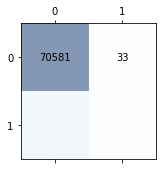

In [61]:
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(CFmat,cmap = plt.cm.Blues, alpha = 0.5)
for i in range(CFmat.shape[0]):
    for j in range(CFmat.shape[1]):
        ax.text(x = j,y = i,s = CFmat[i,j],va='center',ha='center')
    plt.show()

In [62]:
from sklearn.metrics import classification_report
print(classification_report(testY,predictY))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     70614
           1       0.58      0.01      0.01      6264

   micro avg       0.92      0.92      0.92     76878
   macro avg       0.75      0.50      0.49     76878
weighted avg       0.89      0.92      0.88     76878



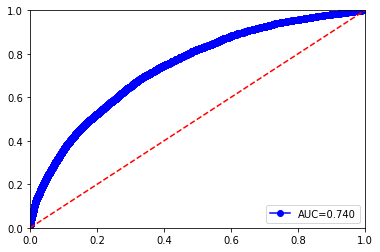

In [63]:
#生成ROC曲线
from sklearn.metrics import roc_curve,auc
fpr,tpr,thresholds =roc_curve(testY,GB.predict_proba(testX)[:,1])
roc_auc = auc(fpr,tpr)
plt.plot(fpr,tpr,'b',marker='o',label='AUC=%0.3f'%roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.show()

In [73]:
# 以下代码训练lightgbm模型并进行预测
import re
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

In [74]:
# 由于lightgbm的输入变量不可有特殊符号，故先删除特殊符号
X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))


#训练数据并利用交叉验证法查看效果，并对test数据集进行预测
clf = LGBMClassifier(
            n_estimators=1000,
            learning_rate=0.05,
            max_depth=8,
            min_split_gain=.01,
            min_child_weight=2,
            silent=-1,
        )

preds = np.zeros(df_test.shape[0])

fold = StratifiedKFold(n_splits=10, shuffle=True)
for n, (train_index, test_index) in enumerate(fold.split(X,y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
            eval_metric="auc", verbose=200, early_stopping_rounds=200)
    
    
    preds += clf.predict_proba(test_X, num_iteration=clf.best_iteration_)[:, 1] / fold.n_splits
    print("ROC AUC score of fold " + str(n+1) + " is: " + str(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])))

fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
    
df_test['TARGET'] = preds
df_test[['SK_ID_CURR', 'TARGET']].to_csv("sub2.csv", index= False)

Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.785534	training's binary_logloss: 0.237908	valid_1's auc: 0.750284	valid_1's binary_logloss: 0.248292
[400]	training's auc: 0.810563	training's binary_logloss: 0.229783	valid_1's auc: 0.749834	valid_1's binary_logloss: 0.24842
Early stopping, best iteration is:
[245]	training's auc: 0.791537	training's binary_logloss: 0.235976	valid_1's auc: 0.750537	valid_1's binary_logloss: 0.24823
ROC AUC score of fold 1 is: 0.7505371522283467
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.784823	training's binary_logloss: 0.238164	valid_1's auc: 0.758509	valid_1's binary_logloss: 0.246434
[400]	training's auc: 0.810853	training's binary_logloss: 0.229905	valid_1's auc: 0.757978	valid_1's binary_logloss: 0.246367
Early stopping, best iteration is:
[313]	training's auc: 0.80016	training's binary_logloss: 0.233381	valid_1's auc: 0.758749	valid_1's binary_logloss: 0.246227
ROC AU

In [80]:
trainX,testX,trainY,testY=train_test_split(X,target,test_size=0.25,random_state=33)

In [84]:
# 生成lightgbm训练结果的混淆矩阵
from sklearn.metrics import confusion_matrix
lgbm=clf.fit(trainX,trainY)
predictY = lgbm.predict(testX)
CFmat = confusion_matrix(y_true=testY,y_pred=predictY)
print(CFmat)

[[70508   106]
 [ 6103   161]]


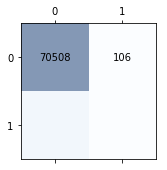

In [85]:
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(CFmat,cmap = plt.cm.Blues, alpha = 0.5)
for i in range(CFmat.shape[0]):
    for j in range(CFmat.shape[1]):
        ax.text(x = j,y = i,s = CFmat[i,j],va='center',ha='center')
    plt.show()

In [86]:
print(classification_report(testY,predictY))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     70614
           1       0.60      0.03      0.05      6264

   micro avg       0.92      0.92      0.92     76878
   macro avg       0.76      0.51      0.50     76878
weighted avg       0.89      0.92      0.88     76878



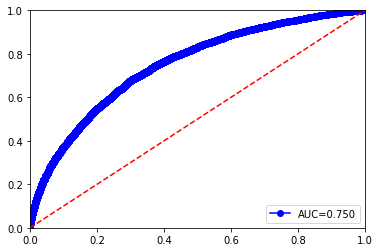

In [87]:
#生成ROC曲线
from sklearn.metrics import roc_curve,auc
fpr,tpr,thresholds =roc_curve(testY,lgbm.predict_proba(testX)[:,1])
roc_auc = auc(fpr,tpr)
plt.plot(fpr,tpr,'b',marker='o',label='AUC=%0.3f'%roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.show()